### Import packages

In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

### Import data

In [2]:
data = pd.read_csv("../input/winequality-red.csv")
data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
fixed acidity           1599 non-null float64
volatile acidity        1599 non-null float64
citric acid             1599 non-null float64
residual sugar          1599 non-null float64
chlorides               1599 non-null float64
free sulfur dioxide     1599 non-null float64
total sulfur dioxide    1599 non-null float64
density                 1599 non-null float64
pH                      1599 non-null float64
sulphates               1599 non-null float64
alcohol                 1599 non-null float64
quality                 1599 non-null int64
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


In [4]:
data.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


In [5]:
from sklearn.preprocessing import LabelEncoder

bins = (2, 5, 8)
group_names = ['bad', 'good']

data['quality'] = pd.cut(data["quality"], bins = bins, labels = group_names)

label_quality = LabelEncoder()

data['quality'] = label_quality.fit_transform(data['quality'].astype(str))
data['quality'].value_counts()

1    855
0    744
Name: quality, dtype: int64

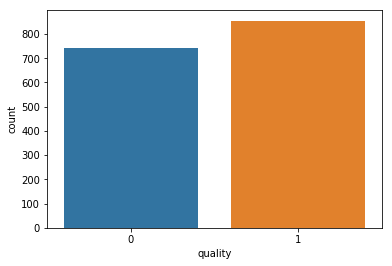

In [6]:
sns.countplot(data['quality'])
plt.show()

 ### Feature Selection (filter method)

* The model is built after selecting the features.
* The filtering here is done using correlation matrix and it is most commonly done using Pearson correlation.

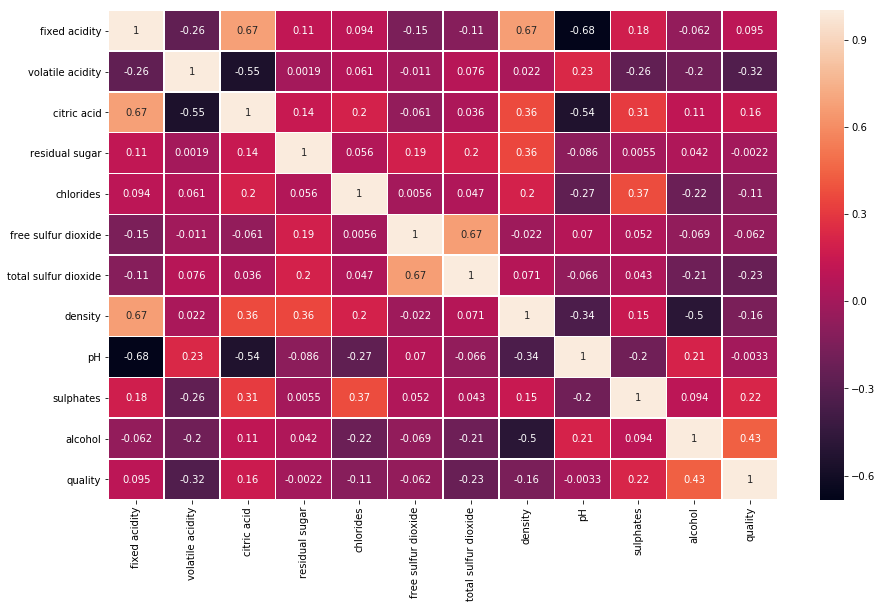

In [7]:
# Pearson correlation
plt.subplots(figsize=(15, 9))
cor = data.corr()
sns.heatmap(cor, annot=True, linewidths=.5)
plt.show()

In [8]:
#correlated features with quality
cor_feat = abs(cor["quality"])

#relevant features
rel_feat = cor_feat[cor_feat>0.2]
rel_feat

volatile acidity        0.321441
total sulfur dioxide    0.231963
sulphates               0.218072
alcohol                 0.434751
quality                 1.000000
Name: quality, dtype: float64

In [9]:
# correlation btw relevant features
data[["volatile acidity","citric acid"]].corr()

,volatile acidity,citric acid
volatile acidity,1.000000,-0.552496
citric acid,-0.552496,1.000000


In [10]:
data[["volatile acidity","sulphates"]].corr()

,volatile acidity,sulphates
volatile acidity,1.000000,-0.260987
sulphates,-0.260987,1.000000


In [11]:
data[["volatile acidity","alcohol"]].corr()

,volatile acidity,alcohol
volatile acidity,1.000000,-0.202288
alcohol,-0.202288,1.000000


Final relevant features are:
volatile acidity, sulphates, alcohol            

### Feature Selection (wrapper method)

* A wrapper method needs one machine learning algorithm and uses its performance as evaluation criteria.
* There are different wrapper methods such as Backward Elimination, Forward Selection, Bidirectional Elimination and RFE.

**Backward Elimination : **
* we feed all the possible features to the model at first
* The performance metric used here to evaluate feature performance is pvalue. 

In [12]:
X = data.drop("quality", axis=1)
y = data["quality"]

In [13]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=.2, random_state=10)

In [14]:
#Backward Elimination
import statsmodels.api as sm
cols = list(X_train.columns)
pmax = 1
while (len(cols)>0):
    p= []
    X_1 = X_train[cols]
    X_1 = sm.add_constant(X_1)
    model = sm.OLS(y_train,X_1).fit()
    p = pd.Series(model.pvalues.values[1:],index = cols)      
    pmax = max(p)
    feature_with_p_max = p.idxmax()
    if(pmax>0.05):
        cols.remove(feature_with_p_max)
    else:
        break

selected_features_BE = cols
selected_features_BE

['fixed acidity',
 'volatile acidity',
 'citric acid',
 'chlorides',
 'free sulfur dioxide',
 'total sulfur dioxide',
 'sulphates',
 'alcohol']

**Recursive feature elimination (RFE) : **

* The goal of recursive feature elimination (RFE) is to select features by recursively considering smaller and smaller sets of features. 
* First, the estimator is trained on the initial set of features and the importance of each feature is obtained either through a coef_ attribute or through a feature_importances_ attribute. 
* Then, the least important features are pruned from current set of features.

In [15]:
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE

model = LinearRegression()

rfe = RFE(model, 8)
X_rfe = rfe.fit_transform(X_train, y_train)

model.fit(X_rfe, y_train)
print(rfe.support_)
print(rfe.ranking_)

[ True  True  True False  True False False  True  True  True  True]
[1 1 1 4 1 2 3 1 1 1 1]


We do that by using loop starting with 1 feature and going up to 11. We then take the one for which the accuracy is highest.

In [16]:
#no of features
nof_list=np.arange(1,11)            
high_score=0
#Variable to store the optimum features
nof=0           
score_list =[]
for n in range(len(nof_list)):
    model = LinearRegression()
    rfe = RFE(model,nof_list[n])
    X_train_rfe = rfe.fit_transform(X_train,y_train)
    X_test_rfe = rfe.transform(X_test)
    model.fit(X_train_rfe,y_train)
    score = model.score(X_test_rfe,y_test)
    score_list.append(score)
    if(score>high_score):
        high_score = score
        nof = nof_list[n]

print("Optimum number of features: %d" %nof)
print("Score with %d features: %f" % (nof, high_score))

Optimum number of features: 10
Score with 10 features: 0.274943


As the optimum number of features is 7. We now feed 10 as number of features to RFE and get the final set of features given by RFE method

In [17]:
cols = list(X_train.columns)
model = LinearRegression()

#Initializing RFE model
rfe = RFE(model, 7)             

#Transforming data using RFE
X_rfe = rfe.fit_transform(X_train,y_train)  

#Fitting the data to model
model.fit(X_rfe,y_train)              
temp = pd.Series(rfe.support_,index = cols)
selected_features_rfe = temp[temp==True].index
print(selected_features_rfe)


Index(['volatile acidity', 'citric acid', 'chlorides', 'density', 'pH',
       'sulphates', 'alcohol'],
      dtype='object')


###  Embedded Method:


* Embedded methods are iterative in a sense that takes care of each iteration of the model training process and carefully extract those features which contribute the most to the training for a particular iteration.
* Regularization methods are the most commonly used embedded methods which penalize a feature given a coefficient threshold.

In [18]:
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso

reg = LassoCV()
reg.fit(X_train, y_train)
print("Best alpha using built-in LassoCV: %f" % reg.alpha_)
print("Best score using built-in LassoCV: %f" %reg.score(X_test,y_test))
coef = pd.Series(reg.coef_, index = X.columns)

Best alpha using built-in LassoCV: 0.004020
Best score using built-in LassoCV: 0.278952


/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


In [19]:
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Lasso picked 7 variables and eliminated the other 4 variables


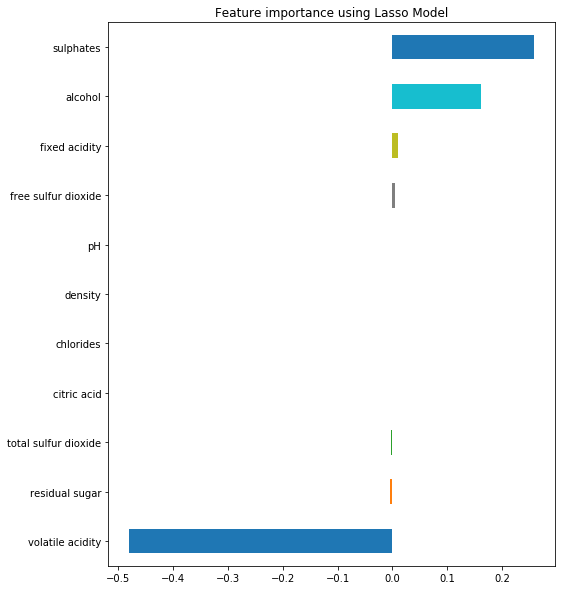

In [20]:
imp_coef = coef.sort_values()
import matplotlib
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Feature importance using Lasso Model")
plt.show()

**For Classification :**
[Follow this link](https://www.kaggle.com/alokevil/red-wine-classification)